# Analysis of unithood

This notebook contains most parts of the analysis on unithood, the strength of association between components of concepts.

In [3]:
CORPUS_NAME = 'genia'
MODEL_SPEC = '_min2_l10'
FREQ_THRESHOLD = 3

In [4]:
# get to root directory of project
import os
os.chdir('/home/kasper/PycharmProjects/discontinuous-concepts/')

from datautils import dataio, annotations as anno
from stats import ngramcounting

# load the corpora
if CORPUS_NAME.lower() == 'pmc':
    corpus = dataio.load_craft_corpus() + dataio.load_genia_corpus()
else:
    corpus = dataio.load_corpus(CORPUS_NAME.lower())
print('Loading n-gram model')
model = ngramcounting.NgramModel.load_model(CORPUS_NAME, MODEL_SPEC)

Loading GENIA corpus ... NOTE: 13 files cannot get Constituent annotations!


100%|██████████| 1599/1599 [00:12<00:00, 127.09it/s]


Loading n-gram model


## Question 1: How strong is the association in regular concepts?

In [51]:
# get all continuous concepts

from stats import conceptstats
cont_concepts = conceptstats.gold_standard_concepts(corpus, discontinuous=False)

Retrieving gold standard concepts ... Skipped 3 concepts not bounded at tokens boundaries.


In [52]:
import nltk
concept_bigrams = {bigram for concept in cont_concepts for bigram in nltk.bigrams(concept)}

In [53]:
import pandas as pd

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'in_concept': [],  'pmi': [], 'll': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)


data = pd.DataFrame(data_dict)

In [54]:
data.head(20)

,bigram,in_concept,pmi,ll,freq
0,"(of, arsenic)",False,2.522915,19.107739,4
1,"(,, similar)",False,-0.347627,0.845113,5
2,"(and, secretion)",False,1.365367,15.650506,11
3,"(,, implicate)",False,0.638141,2.443953,6
4,"(redox, state)",True,6.409419,43.953821,3
5,"(,, dibutyryl)",False,2.295750,12.561360,3
6,"(into, the)",False,1.946253,199.778295,80
7,"(and, atopic)",False,2.049704,10.131690,3
8,"(;, 17)",True,4.803986,38.784870,4
9,"(regulator, ,)",False,0.534762,1.514687,5


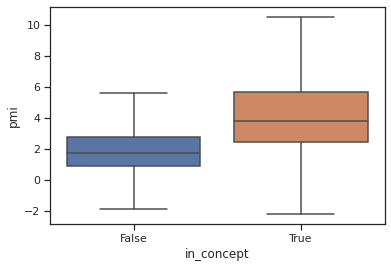

In [55]:
import seaborn as sns
sns.boxplot(x='in_concept', y='pmi', data=data, showfliers=False)

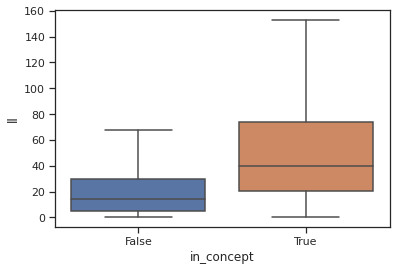

In [56]:
sns.boxplot(x='in_concept', y='ll', data=data, showfliers=False)

In [57]:
# we can perform t-tests etc.

In [49]:
from scipy import stats

In [65]:
import pingouin
pingouin.mwu(data[data['in_concept'] == True]['pmi'],
             data[data['in_concept'] == False]['pmi'])

,U-val,tail,p-val,RBC,CLES
MWU,72471335.0,two-sided,0.0,-0.553,0.776


Conclusion: concept bigrams _do_ have higher association.

## Question 2: How does it look for bigrams in DC's?

In [67]:
disc_concepts = conceptstats.gold_standard_concepts(corpus, continuous=False,
                                                    discontinuous=True)
dc_bigrams = {bigram for concept in disc_concepts for bigram in nltk.bigrams(concept)}

Retrieving gold standard concepts ... Skipped 0 concepts not bounded at tokens boundaries.


In [68]:
import pandas as pd

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'type': [],  'pmi': [], 'll': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    
    if bigram in concept_bigrams:
        if bigram in dc_bigrams:
            bigram_type = 'both'
        else:
            bigram_type = 'only_CC'
    elif bigram in dc_bigrams:
        bigram_type = 'only_DC'
    else:
        bigram_type = 'neither'
    
    data_dict['type'].append(bigram_type)


data = pd.DataFrame(data_dict)

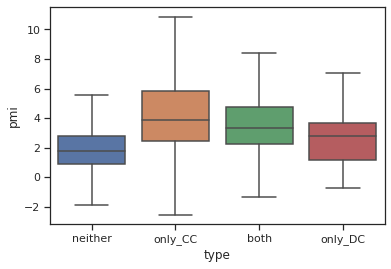

In [69]:
sns.boxplot(x='type', y='pmi', data=data, showfliers=False)

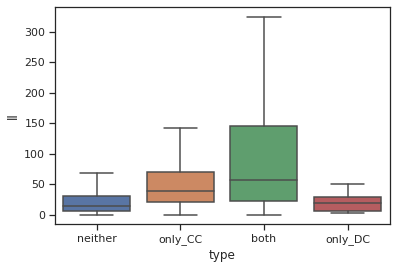

In [70]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

In [71]:
pingouin.kruskal(data, 'll', 'type')

,Source,ddof1,H,p-unc
Kruskal,type,3,2958.827,0.0


In [46]:
# However, notice that
len(data[data['type'] == 'only_DC'])

16

In [47]:
# compared to e.g.
len(data[data['type'] == 'both'])

786

## Question 3: What is the association across the gap?

In [76]:
from collections import defaultdict

gap_bigrams = defaultdict(list)
cont_bigrams = defaultdict(list)
dc_sample = {dc for doc in corpus for dc in doc.get_annotations(anno.DiscontinuousConcept)}
for dc in dc_sample:
    tokens = dc.get_concept_tokens()
    norm_concept = dc.normalized_concept()
    for i in range(len(tokens) - 1):
        t1, t2 = tokens[i], tokens[i+1]
        bigram = norm_concept[i:i + 2]
        if t2.span[0] - t1.span[-1] > 2:
            gap_bigrams[bigram].append(dc)
        else:
            cont_bigrams[bigram].append(dc)

In [98]:
data_dict = {'bigram': [], 'freq': [], 'pmi': [], 'll': [], 'type': []}

all_bigrams = set(gap_bigrams.keys()).union(set(cont_bigrams.keys()))
for bigram in all_bigrams:
    # skip if not frequent enough
    if model.freq(bigram) < FREQ_THRESHOLD:
        continue

    data_dict['bigram'].append(bigram)
    data_dict['freq'].append(model.freq(bigram))

    contingency_table = model.contingency_table(bigram[0], bigram[1])
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)

    # how it occurs
    if bigram in gap_bigrams:
        if bigram in cont_bigrams: 
            type_ = 'both'
        else:
            type_ = 'only_gap'
    else:
        type_ = 'only_cont'
    data_dict['type'].append(type_)

data = pd.DataFrame(data_dict)

### NOTE

That a bigram occurs as `only_gap` means that it occurs only in gap position for DC's. However, those bigrams can just as well occur in CC's as well, thereby getting a high association.

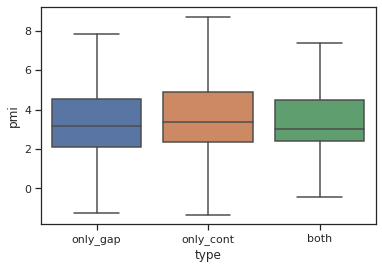

In [99]:
sns.boxplot(x='type', y='pmi', data=data, showfliers=False)

In [100]:
pingouin.kruskal(data, 'pmi', 'type')

,Source,ddof1,H,p-unc
Kruskal,type,2,3.771,0.151734


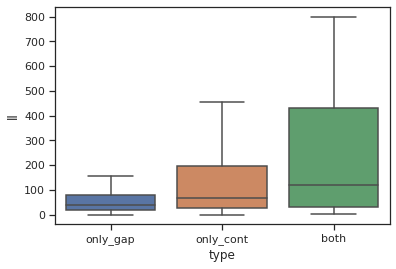

In [101]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

In [106]:
data[data['type'] == 'only_cont'].sort_values(['pmi', 'll'], ascending=False)

,bigram,freq,pmi,ll,type
105,"(tetanus, toxoid)",5,10.763770,133.381513,only_cont
438,"(acetyl, transferase)",9,10.042452,203.659682,only_cont
760,"(squirrel, monkey)",15,9.625153,316.760035,only_cont
507,"(k+, channel)",10,9.598766,212.262071,only_cont
310,"(leucine, zipper)",6,9.531626,128.034776,only_cont
...,...,...,...,...,...
488,"(lymphocyte, cell)",6,-0.784337,5.784182,only_cont
465,"(a, ()",36,-0.929323,45.766798,only_cont
686,"((, a)",24,-1.321365,72.986722,only_cont
277,"(t, ()",5,-1.495857,23.906769,only_cont


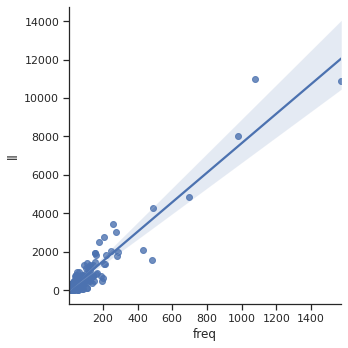

In [103]:
sns.lmplot('freq', 'll', data)